In [ ]:
pip install datasets transformers torch networkx sentence-transformers nltk rouge-score

In [1]:
import torch
import numpy as np
import pandas as pd
import networkx as nx
import os
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sentence_transformers import SentenceTransformer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
from huggingface_hub import hf_hub_download
import shutil

F:\miniconda3\Lib\site-packages\transformers\utils\hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [3]:
# Step 1: Create local directories
MODEL_CACHE_DIR = "./models"
DATA_CACHE_DIR = "./data"
os.makedirs(MODEL_CACHE_DIR, exist_ok=True)
os.makedirs(DATA_CACHE_DIR, exist_ok=True)

In [8]:
from datasets import load_dataset
dataset = load_dataset("rajpurkar/squad_v2", split="validation[:100]", cache_dir=DATA_CACHE_DIR)

# Step 4: Download GPT2-medium model
tokenizer = AutoTokenizer.from_pretrained("gpt2-medium", cache_dir = MODEL_CACHE_DIR)

generator = pipeline(
    "text-generation", 
    model="gpt2-medium", 
    tokenizer="gpt2-medium",
    device=0 if torch.cuda.is_available() else -1,
    model_kwargs={"cache_dir": MODEL_CACHE_DIR},
    pad_token_id=tokenizer.eos_token_id
)

# Step 5: Download Sentence Transformer model
embedder = SentenceTransformer(
    "all-MiniLM-L6-v2",
    cache_folder=MODEL_CACHE_DIR
)

Device set to use cuda:0


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 100/100 [06:31<00:00,  3.92s/it]


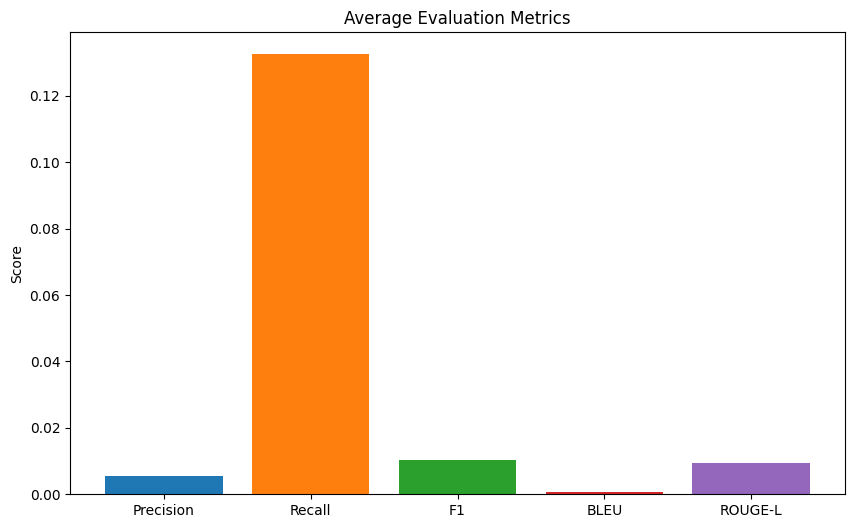

C:\Users\ashiq\AppData\Local\Temp\ipykernel_9076\4284139648.py:135: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([precisions, recalls, f1s, bleus, rouges], labels=["Precision", "Recall", "F1", "BLEU", "ROUGE-L"])


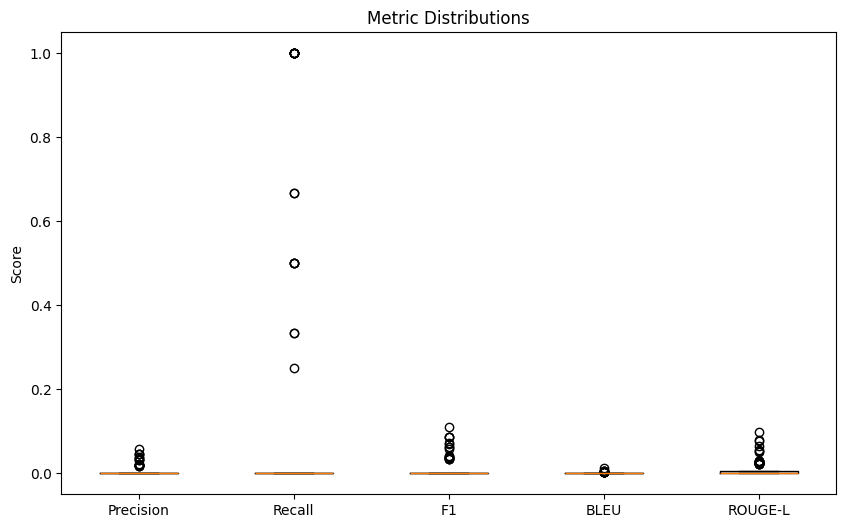

Average Metrics:
Precision: 0.0054
Recall: 0.1325
F1: 0.0103
BLEU: 0.0006
ROUGE-L: 0.0094


In [9]:
# Step 3: Build Knowledge Graph for Graph RAG
def build_knowledge_graph(dataset):
    G = nx.DiGraph()
    for item in dataset:
        context = item["context"]
        question = item["question"]
        answers = item["answers"]["text"] if item["answers"]["text"] else ["No answer"]
        # Add nodes and edges
        G.add_node(context, type="context")
        G.add_node(question, type="question")
        for answer in answers:
            G.add_node(answer, type="answer")
            G.add_edge(context, answer, relation="contains")
            G.add_edge(question, answer, relation="queries")
    return G

G = build_knowledge_graph(dataset)

# Step 4: Vector Store for Retrieval
def create_vector_store(dataset):
    contexts = [item["context"] for item in dataset]
    embeddings = embedder.encode(contexts, convert_to_tensor=True)
    return contexts, embeddings

contexts, context_embeddings = create_vector_store(dataset)

# Step 5: Retrieval Function with Reranking
def retrieve_contexts(question, top_k=5):
    question_embedding = embedder.encode([question], convert_to_tensor=True)
    similarities = torch.cosine_similarity(question_embedding, context_embeddings).cpu().numpy()
    top_k_indices = similarities.argsort()[-top_k:][::-1]
    initial_contexts = [contexts[i] for i in top_k_indices]

    # Reranking using semantic similarity
    scores = [(ctx, embedder.encode([f"{question} {ctx}"], convert_to_tensor=True).norm().item()) for ctx in initial_contexts]
    scores.sort(key=lambda x: x[1], reverse=True)
    return [ctx for ctx, _ in scores[:3]]  # Return top 3 after reranking

# Step 6: Graph RAG Retrieval
def graph_rag_retrieve(question, G):
    # Find related contexts via graph traversal
    related_contexts = []
    for node in G.nodes:
        if G.nodes[node].get("type") == "question" and node.lower() == question.lower():
            for neighbor in G.neighbors(node):
                if G.nodes[neighbor].get("type") == "answer":
                    for context in G.predecessors(neighbor):
                        if G.nodes[context].get("type") == "context":
                            related_contexts.append(context)
    return related_contexts[:3]

# Step 7: Self-RAG Mechanism
def self_rag_generate(question, contexts, max_attempts=2):
    best_response = None
    best_score = -float("inf")

    for _ in range(max_attempts):
        prompt = f"Question: {question}\nContext: {' '.join(contexts)}\nAnswer:"
        response = generator(prompt, max_new_tokens=100, num_return_sequences=1, truncation=True)[0]["generated_text"]
        # Evaluate response quality using embedding similarity
        response_embedding = embedder.encode([response], convert_to_tensor=True)
        question_embedding = embedder.encode([question], convert_to_tensor=True)
        score = torch.cosine_similarity(response_embedding, question_embedding).item()

        if score > best_score:
            best_score = score
            best_response = response.split("Answer:")[-1].strip()

    return best_response

# Step 8: Hybrid RAG Pipeline
def hybrid_rag(question, G):
    # Combine Graph RAG and Vector Retrieval
    graph_contexts = graph_rag_retrieve(question, G)
    vector_contexts = retrieve_contexts(question)
    combined_contexts = list(set(graph_contexts + vector_contexts))[:3]
    # Generate answer using Self-RAG
    answer = self_rag_generate(question, combined_contexts)
    return answer, combined_contexts

# Step 9: Evaluation Metrics
def evaluate_metrics(pred, true):
    # Convert to binary labels for precision, recall, f1 (simplified exact match)
    pred_tokens = set(pred.lower().split())
    true_tokens = set(true.lower().split())
    common = pred_tokens & true_tokens
    precision = len(common) / len(pred_tokens) if pred_tokens else 0
    recall = len(common) / len(true_tokens) if true_tokens else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    # BLEU with smoothing to handle zero n-gram overlaps
    smoothie = SmoothingFunction().method1
    bleu = sentence_bleu([true.split()], pred.split(), smoothing_function=smoothie)

    # ROUGE-L
    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    rouge = scorer.score(true, pred)["rougeL"].fmeasure  # Corrected from f1_score to fmeasure

    return precision, recall, f1, bleu, rouge

# Step 10: Run Evaluation
precisions, recalls, f1s, bleus, rouges = [], [], [], [], []
for item in tqdm(dataset, desc="Evaluating"):
    question = item["question"]
    true_answer = item["answers"]["text"][0] if item["answers"]["text"] else "No answer"
    pred_answer, _ = hybrid_rag(question, G)

    precision, recall, f1, bleu, rouge = evaluate_metrics(pred_answer, true_answer)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    bleus.append(bleu)
    rouges.append(rouge)

# Step 11: Compute Average Metrics
avg_metrics = {
    "Precision": np.mean(precisions),
    "Recall": np.mean(recalls),
    "F1": np.mean(f1s),
    "BLEU": np.mean(bleus),
    "ROUGE-L": np.mean(rouges)
}

# Step 12: Visualizations
# Bar chart for average metrics
plt.figure(figsize=(10, 6))
plt.bar(avg_metrics.keys(), avg_metrics.values(), color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"])
plt.title("Average Evaluation Metrics")
plt.ylabel("Score")
plt.savefig("metrics_bar.png")
plt.show()

# Boxplot for metric distributions
plt.figure(figsize=(10, 6))
plt.boxplot([precisions, recalls, f1s, bleus, rouges], labels=["Precision", "Recall", "F1", "BLEU", "ROUGE-L"])
plt.title("Metric Distributions")
plt.ylabel("Score")
plt.savefig("metrics_boxplot.png")
plt.show()



# ```

# Print average metrics
print("Average Metrics:")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value:.4f}")
# ```

In [10]:
# ```python
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# Step 1: Define Baseline RAG Pipelines
def vector_only_rag(question):
    # Retrieve contexts using vector search only
    contexts = retrieve_contexts(question, top_k=3)  # Use existing retrieve_contexts function
    # Generate answer using Self-RAG
    answer = self_rag_generate(question, contexts)
    return answer, contexts

def graph_only_rag(question, G):
    # Retrieve contexts using graph traversal only
    contexts = graph_rag_retrieve(question, G)  # Use existing graph_rag_retrieve function
    # Generate answer using Self-RAG
    answer = self_rag_generate(question, contexts)
    return answer, contexts

# Step 2: Evaluate All Approaches
hybrid_metrics = {"Precision": [], "Recall": [], "F1": [], "BLEU": [], "ROUGE-L": []}
vector_metrics = {"Precision": [], "Recall": [], "F1": [], "BLEU": [], "ROUGE-L": []}
graph_metrics = {"Precision": [], "Recall": [], "F1": [], "BLEU": [], "ROUGE-L": []}

for item in tqdm(dataset, desc="Evaluating All RAG Approaches"):
    question = item["question"]
    true_answer = item["answers"]["text"][0] if item["answers"]["text"] else "No answer"

    # Hybrid RAG
    hybrid_answer, _ = hybrid_rag(question, G)
    hybrid_precision, hybrid_recall, hybrid_f1, hybrid_bleu, hybrid_rouge = evaluate_metrics(hybrid_answer, true_answer)
    hybrid_metrics["Precision"].append(hybrid_precision)
    hybrid_metrics["Recall"].append(hybrid_recall)
    hybrid_metrics["F1"].append(hybrid_f1)
    hybrid_metrics["BLEU"].append(hybrid_bleu)
    hybrid_metrics["ROUGE-L"].append(hybrid_rouge)

    # Vector-only RAG
    vector_answer, _ = vector_only_rag(question)
    vector_precision, vector_recall, vector_f1, vector_bleu, vector_rouge = evaluate_metrics(vector_answer, true_answer)
    vector_metrics["Precision"].append(vector_precision)
    vector_metrics["Recall"].append(vector_recall)
    vector_metrics["F1"].append(vector_f1)
    vector_metrics["BLEU"].append(vector_bleu)
    vector_metrics["ROUGE-L"].append(vector_rouge)

    # Graph-only RAG
    graph_answer, _ = graph_only_rag(question, G)
    graph_precision, graph_recall, graph_f1, graph_bleu, graph_rouge = evaluate_metrics(graph_answer, true_answer)
    graph_metrics["Precision"].append(graph_precision)
    graph_metrics["Recall"].append(graph_recall)
    graph_metrics["F1"].append(graph_f1)
    graph_metrics["BLEU"].append(graph_bleu)
    graph_metrics["ROUGE-L"].append(graph_rouge)

# Step 3: Compute Average Metrics
avg_hybrid = {k: np.mean(v) for k, v in hybrid_metrics.items()}
avg_vector = {k: np.mean(v) for k, v in vector_metrics.items()}
avg_graph = {k: np.mean(v) for k, v in graph_metrics.items()}

# Step 4: Grouped Bar Chart
metrics = ["Precision", "Recall", "F1", "BLEU", "ROUGE-L"]
x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, [avg_hybrid[m] for m in metrics], width, label="Hybrid RAG", color="#1f77b4")
plt.bar(x, [avg_vector[m] for m in metrics], width, label="Vector-only RAG", color="#ff7f0e")
plt.bar(x + width, [avg_graph[m] for m in metrics], width, label="Graph-only RAG", color="#2ca02c")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Comparison of RAG Approaches")
plt.xticks(x, metrics)
plt.legend()
plt.savefig("rag_comparison_bar.png")
plt.show()

# Step 5: Radar Chart
from math import pi

categories = metrics
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Hybrid RAG
values = [avg_hybrid[m] for m in metrics] + [avg_hybrid[metrics[0]]]
ax.plot(angles, values, linewidth=2, linestyle="solid", label="Hybrid RAG", color="#1f77b4")
ax.fill(angles, values, color="#1f77b4", alpha=0.25)

# Vector-only RAG
values = [avg_vector[m] for m in metrics] + [avg_vector[metrics[0]]]
ax.plot(angles, values, linewidth=2, linestyle="solid", label="Vector-only RAG", color="#ff7f0e")
ax.fill(angles, values, color="#ff7f0e", alpha=0.25)

# Graph-only RAG
values = [avg_graph[m] for m in metrics] + [avg_graph[metrics[0]]]
ax.plot(angles, values, linewidth=2, linestyle="solid", label="Graph-only RAG", color="#2ca02c")
ax.fill(angles, values, color="#2ca02c", alpha=0.25)

ax.set_xticks(angles[:-1], categories)
ax.set_title("Radar Chart: RAG Approaches Comparison")
plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
plt.savefig("rag_comparison_radar.png")
plt.show()

# Step 6: Line Plot for Cumulative F1
cumulative_hybrid_f1 = np.cumsum(hybrid_metrics["F1"]) / np.arange(1, len(hybrid_metrics["F1"]) + 1)
cumulative_vector_f1 = np.cumsum(vector_metrics["F1"]) / np.arange(1, len(vector_metrics["F1"]) + 1)
cumulative_graph_f1 = np.cumsum(graph_metrics["F1"]) / np.arange(1, len(graph_metrics["F1"]) + 1)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_hybrid_f1, label="Hybrid RAG", color="#1f77b4")
plt.plot(cumulative_vector_f1, label="Vector-only RAG", color="#ff7f0e")
plt.plot(cumulative_graph_f1, label="Graph-only RAG", color="#2ca02c")
plt.xlabel("Sample Number")
plt.ylabel("Cumulative Average F1 Score")
plt.title("Cumulative F1 Score Across Samples")
plt.legend()
plt.savefig("rag_cumulative_f1.png")
plt.show()


# Print Average Metrics for Comparison
print("Hybrid RAG Average Metrics:")
for metric, value in avg_hybrid.items():
    print(f"{metric}: {value:.4f}")

print("\nVector-only RAG Average Metrics:")
for metric, value in avg_vector.items():
    print(f"{metric}: {value:.4f}")

print("\nGraph-only RAG Average Metrics:")
for metric, value in avg_graph.items():
    print(f"{metric}: {value:.4f}")
# ```

Evaluating All RAG Approaches:  50%|█████████████████████████                         | 50/100 [09:48<09:48, 11.78s/it]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
